In [1]:
import pandas as pd
import datetime
import numpy as np
import pandas_datareader.data as web
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
%matplotlib inline

## Data Download
#### Pandas web data reader is an extension of pandas library to communicate with most updated financial data. This will include sources as: Yahoo Finance, Google Finance, Enigma, etc.

In [2]:
start = datetime.datetime(2011, 1, 1)
end = datetime.datetime(2020, 7, 31)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-27,379.619995,373.920013,374.839996,379.239990,30303500.0,379.239990
2020-07-28,378.200012,372.989990,377.470001,373.010010,25906400.0,373.010010
2020-07-29,380.920013,374.850006,375.000000,380.160004,22582300.0,380.160004
2020-07-30,385.190002,375.070007,376.750000,384.760010,39532500.0,384.760010
2020-07-31,425.660004,403.299988,411.540009,425.040009,93584200.0,425.040009


## EDA

#### Moving Average

In [3]:
close = df['Adj Close']
moving_avg = close.rolling(130).mean()

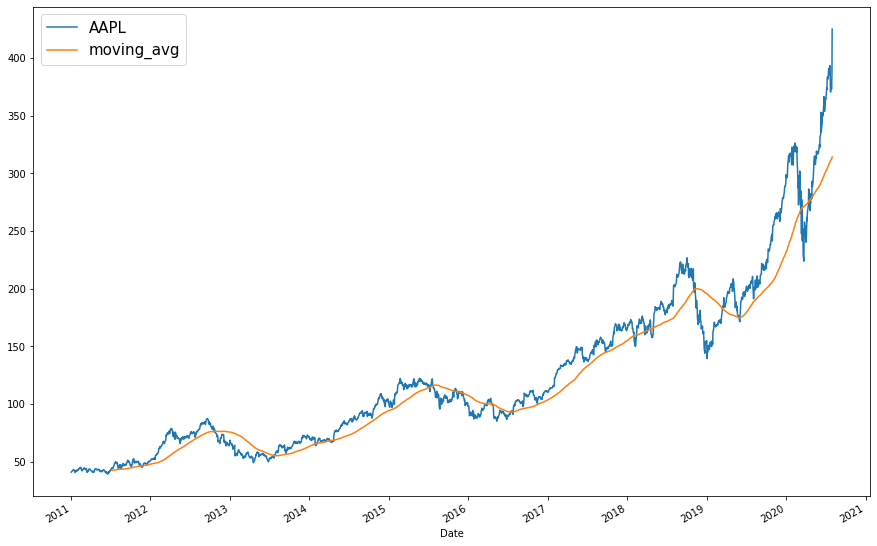

In [4]:
plt.figure(figsize=(15,10))
close.plot(label='AAPL')
moving_avg.plot(label='moving_avg')
plt.legend(fontsize=15)

#### Return

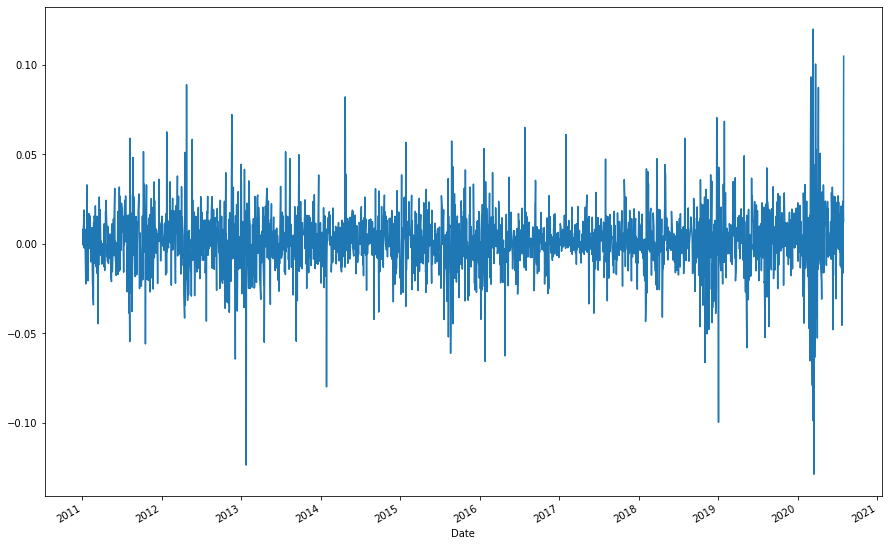

In [5]:
rets = close / close.shift(1) - 1
rets.plot(label='return', figsize=(15,10))

## Feature Engineering

In [7]:
dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
dfreg['Volatility'] = rets.rolling(130).std()
dfreg['Moving_average'] = moving_avg
dfreg.tail()

,Adj Close,Volume,HL_PCT,PCT_change,Volatility,Moving_average
Date,,,,,,
2020-07-27,379.239990,30303500.0,1.503001,1.173833,0.033061,311.808198
2020-07-28,373.010010,25906400.0,1.396751,-1.181549,0.033100,312.246028
2020-07-29,380.160004,22582300.0,1.596698,1.376001,0.033134,312.727148
2020-07-30,384.760010,39532500.0,2.630210,2.126081,0.033144,313.250694
2020-07-31,425.040009,93584200.0,5.260685,3.280362,0.034226,314.155722


## Pre-processing

In [8]:
from sklearn.preprocessing import scale

# Drop missing value
dfreg.dropna(inplace=True)

forecast_out = 22

# Creating the label
dfreg['label'] = dfreg['Adj Close'].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))

# Scale the X so that everyone can have the same distribution for regression
X = scale(X)

X_OOS = X[-forecast_out:]
X_IS = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['label'])
y_OOS = y[-forecast_out:]
y_IS = y[:-forecast_out]

## Model fitting

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
# from xgboost import XGBRegressor

In [10]:
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=0)
rf = RandomForestRegressor(n_estimators=100, max_features=6, n_jobs=-1, random_state=0)
gb = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=0)

In [11]:
lr.fit(X_IS, y_IS)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
dt.fit(X_IS, y_IS)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [1]:
rf.fit(X_IS, y_IS)

NameError: name 'rf' is not defined

In [14]:
gb.fit(X_IS, y_IS)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

## Prediction

In [15]:
lr_pred = pd.Series(lr.predict(X_OOS), index=df.index[-forecast_out:])
dt_pred = pd.Series(dt.predict(X_OOS), index=df.index[-forecast_out:])
rf_pred = pd.Series(rf.predict(X_OOS), index=df.index[-forecast_out:])
gb_pred = pd.Series(gb.predict(X_OOS), index=df.index[-forecast_out:])

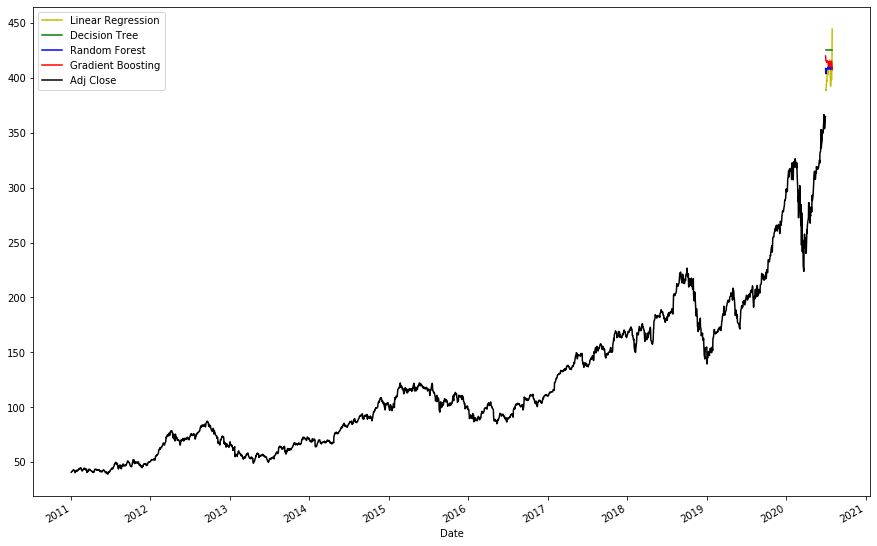

In [16]:
plt.figure(figsize=(15,10))
lr_pred.plot(label='Linear Regression', c='y')
dt_pred.plot(label='Decision Tree', c='g')
rf_pred.plot(label='Random Forest', c='b')
gb_pred.plot(label='Gradient Boosting', c='r')
df['Adj Close'][:-forecast_out].plot(c='k')
plt.legend()

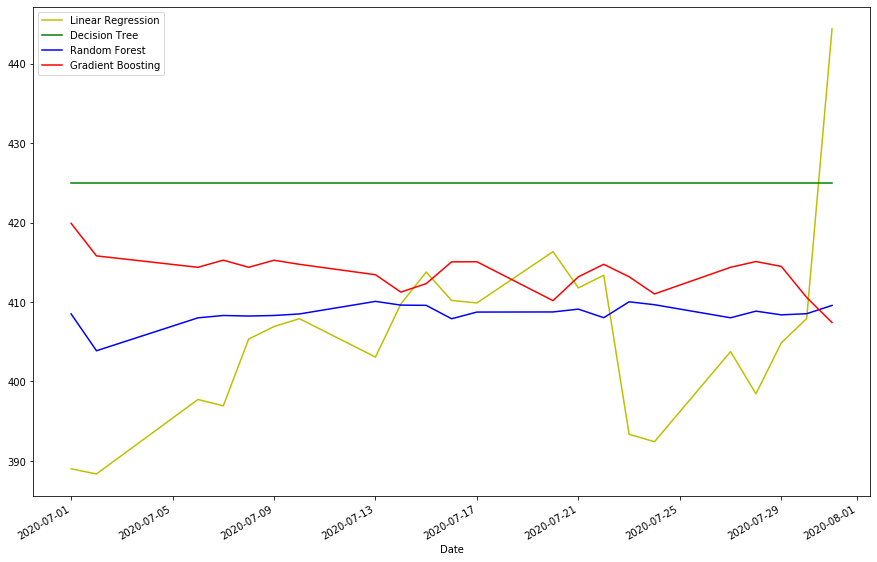

In [17]:
plt.figure(figsize=(15,10))
lr_pred.plot(label='Linear Regression', c='y')
dt_pred.plot(label='Decision Tree', c='g')
rf_pred.plot(label='Random Forest', c='b')
gb_pred.plot(label='Gradient Boosting', c='r')
plt.legend()